In [63]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
import torch.optim as optim
from torchmetrics import Accuracy
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Settings 

torch.set_printoptions(precision=3)

In [95]:
transform_normalize = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])


In [96]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                download=True, transform=transform_normalize)

mnist_testset = torchvision.datasets.MNIST(root='./data', train=False,
                                 download=True, transform=transform_normalize)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [97]:
trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=64,
                                            shuffle=False, num_workers=2)

In [6]:
x_train = torch.stack([sample[0] for sample in ConcatDataset([mnist_trainset])])

x_test = torch.stack([sample[0] for sample in ConcatDataset([mnist_testset])])

In [98]:
x_train.shape

torch.Size([60000, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


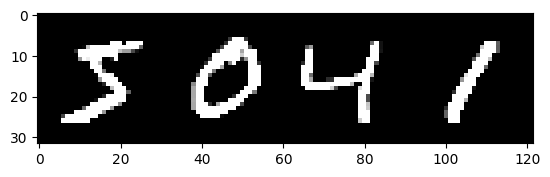

In [14]:
# show image of shape (1, 28, 28)

def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(x_train[0:4]))

# LeNet-5
### for MNIST data set

In [99]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, return_intermediate=False):
        outputs = {}

        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        outputs['conv1'] = x
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        outputs['conv2'] = x
        x = x.view(-1, self.num_flat_features(x))
        outputs['flatten'] = x
        x = F.relu(self.fc1(x))
        outputs['fc1'] = x
        x = F.relu(self.fc2(x))
        outputs['fc2'] = x
        x = self.fc3(x)
        outputs['fc3'] = x

        if return_intermediate:
            return outputs, x
        else:
            return  x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    

In [100]:
class LeNet5V1(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
            
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.feature(x))

In [102]:
# # pass single image through the network
model = LeNet()
model5 = LeNet5V1()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [44]:
# pass single image through the network
outs, x_out = model(x_train[0:1], return_intermediate=True)

In [60]:
outs5 = model5(x_train[0:1])

In [103]:
summary(model=model5, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5V1 (LeNet5V1)                      [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 1, 28, 28]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 28, 28]       156                  True
│    └─Tanh (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Tanh (4)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classifi

In [104]:
summary(model=model, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet (LeNet)                            [1, 1, 28, 28]       [1, 10]              --                   True
├─Conv2d (conv1)                         [1, 1, 28, 28]       [1, 6, 26, 26]       60                   True
├─Conv2d (conv2)                         [1, 6, 13, 13]       [1, 16, 11, 11]      880                  True
├─Linear (fc1)                           [1, 400]             [1, 120]             48,120               True
├─Linear (fc2)                           [1, 120]             [1, 84]              10,164               True
├─Linear (fc3)                           [1, 84]              [1, 10]              850                  True
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.21
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29

# Layer 1 - Conv2d 

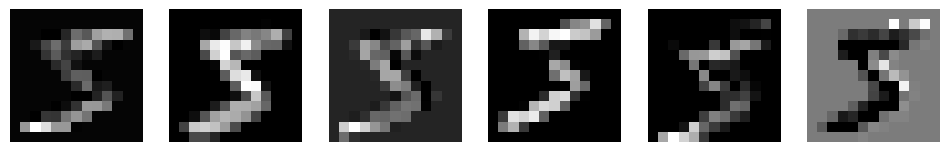

In [19]:
feature_maps = outs['conv1'].detach().cpu().numpy()


fig, axes = plt.subplots(1, len(feature_maps[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

# Layer 2 - Conv2d

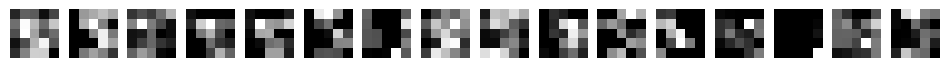

In [20]:
feature_maps = outs['conv2'].detach().cpu().numpy()

fig, axes = plt.subplots(1, len(feature_maps[0]), figsize=(12, 6))
for idx, feature_map in enumerate(feature_maps[0]):
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].axis('off')
plt.show()

In [105]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=10)

In [92]:
accuracy = accuracy.to(device)
model = LeNet().to(device)
model5 = LeNet5V1().to(device)

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times
    train_loss, train_acc = 0, 0
    for X, y in trainloader:
        X, y = X.to(device), y.to(device)

        model5.train()

        y_pred = model5(X)

        loss = criterion(y_pred, y)
        train_loss += loss.item()

        acc = accuracy(y_pred, y)
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)



In [107]:

for epoch in range(10):  # loop over the dataset multiple times
    
    correct = 0
    total = 0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)  # Move inputs and labels to the correct device
        model5.train()
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model5(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


print('Finished Training')

Epoch [1/10], Loss: 0.2784, Accuracy: 92.02%
Epoch [2/10], Loss: 0.0878, Accuracy: 97.31%
Epoch [3/10], Loss: 0.0623, Accuracy: 98.07%
Epoch [4/10], Loss: 0.0482, Accuracy: 98.49%
Epoch [5/10], Loss: 0.0388, Accuracy: 98.77%
Epoch [6/10], Loss: 0.0328, Accuracy: 98.98%
Epoch [7/10], Loss: 0.0276, Accuracy: 99.12%
Epoch [8/10], Loss: 0.0253, Accuracy: 99.16%
Epoch [9/10], Loss: 0.0203, Accuracy: 99.34%
Epoch [10/10], Loss: 0.0187, Accuracy: 99.37%
Finished Training


# CIFAR10